In [1]:
# %cd Yet-Another-EfficientDet-Pytorch
# /home/Fashion/Yet-Another-EfficientDet-Pytorch/logs/fashion_full-epoch_d0_HO-False/efficientdet-d0_38_55575.pth

In [2]:
%cd ..

/Users/kunwo/Documents/development/979/work/Yet-Another-EfficientDet-Pytorch


In [3]:
import argparse
import datetime
import os
import traceback

import numpy as np
import torch
import yaml

import albumentations as A
from tensorboardX import SummaryWriter
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from tqdm.autonotebook import tqdm

from efficientdet.mydataset import CocoDataset, CocoDatasetForAlbumentations
from efficientdet.mydataset import Resizer, Normalizer, Augmenter, collater
from efficientdet.loss import FocalLoss
from utils.sync_batchnorm import patch_replication_callback
from utils.utils import replace_w_sync_bn, CustomDataParallel, get_last_weights, init_weights, boolean_string

import cv2

/var/folders/j4/52q_m8_113nd4338j3hm57wr0000gn/T/ipykernel_28300/4213054722.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
class Params:
    def __init__(self, project_file):
        with open(project_file) as f:
            self.params = yaml.safe_load(f)

    def __getattr__(self, item):
        return self.params.get(item, None)

# print current path
print(os.getcwd())

params = Params(f'./projects/fashion.yml')
training_params = {
    'batch_size': 1,
    'shuffle': False,
    'drop_last': True,
    'collate_fn': collater,
    'num_workers': 1
}
# make option with dot dict
opt = {
    'compound_coef': 4,
    'num_workers': 1,
    'data_path': '../dataset/',
    'compound_coef': 3,
}
opt = argparse.Namespace(**opt)

/Users/kunwo/Documents/development/979/work/Yet-Another-EfficientDet-Pytorch


In [5]:
import cv2
import matplotlib.pyplot as plt

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


import numpy as np

def random_box_color():
    # random hsv color: saturation, brightness is always maximum
    hsv_color = np.array([np.random.randint(0, 179), 255, 100], dtype=np.uint8)

    # convert (h, s, v) to (r, g, b) color space
    rgb_color = cv2.cvtColor(np.array([[hsv_color]], dtype=np.uint8), cv2.COLOR_HSV2RGB)[0][0] / 255.

    return rgb_color.tolist()

print(random_box_color())


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, x_max, y_max = map(int, bbox)
   
    # print(img)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), color, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name, scores, plot=None):
    img = image.copy()
    for bbox, category_id, score in zip(bboxes, category_ids, scores):
        if score < 0.3:
            continue
        if category_id not in category_id_to_name:
            continue
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name, random_box_color())
    
    if plot is None:
        plt.figure(figsize=(12, 12))
        plt.axis('off')
        plt.imshow(img)
    else:
        plot.imshow(img)

[0.0, 0.39215686274509803, 0.36470588235294116]


loading annotations into memory...
Done (t=3.90s)
creating index...
index created!
loading annotations into memory...
Done (t=3.44s)
creating index...
index created!
loading annotations into memory...
Done (t=5.82s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


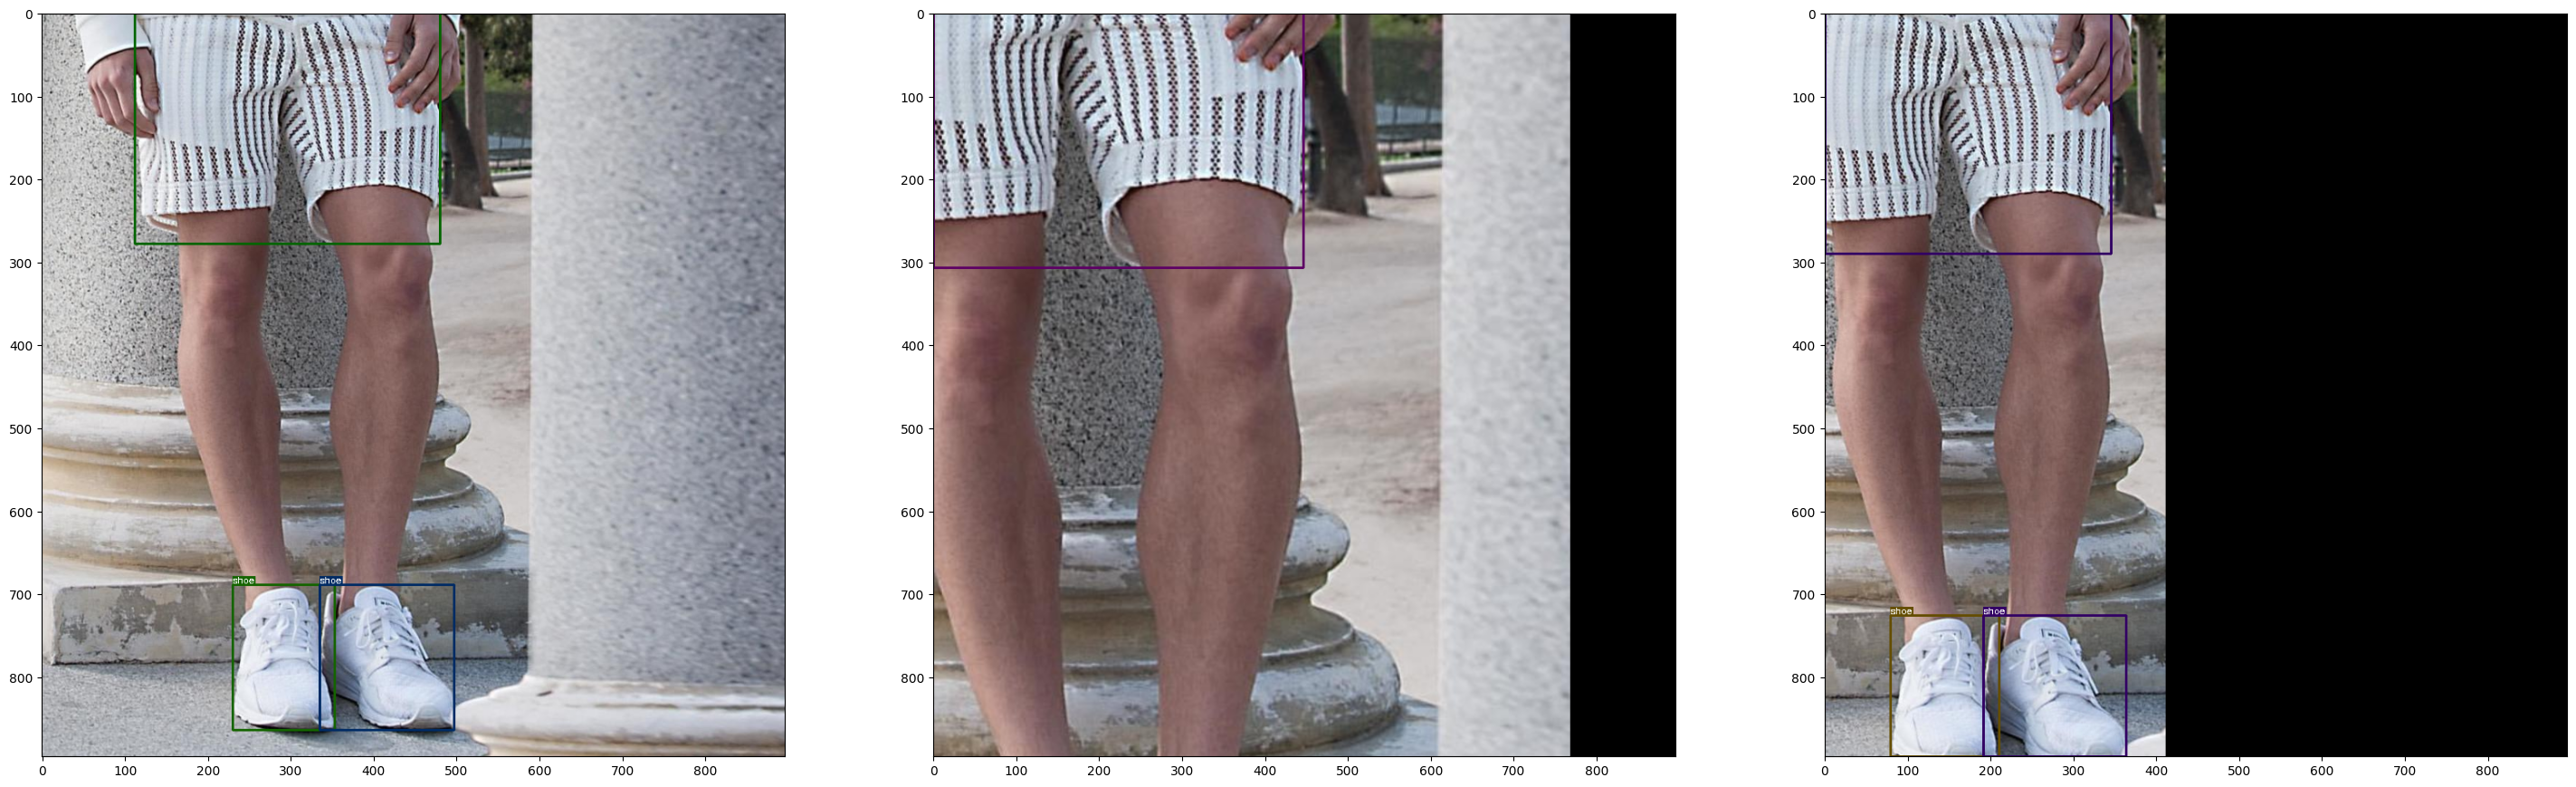

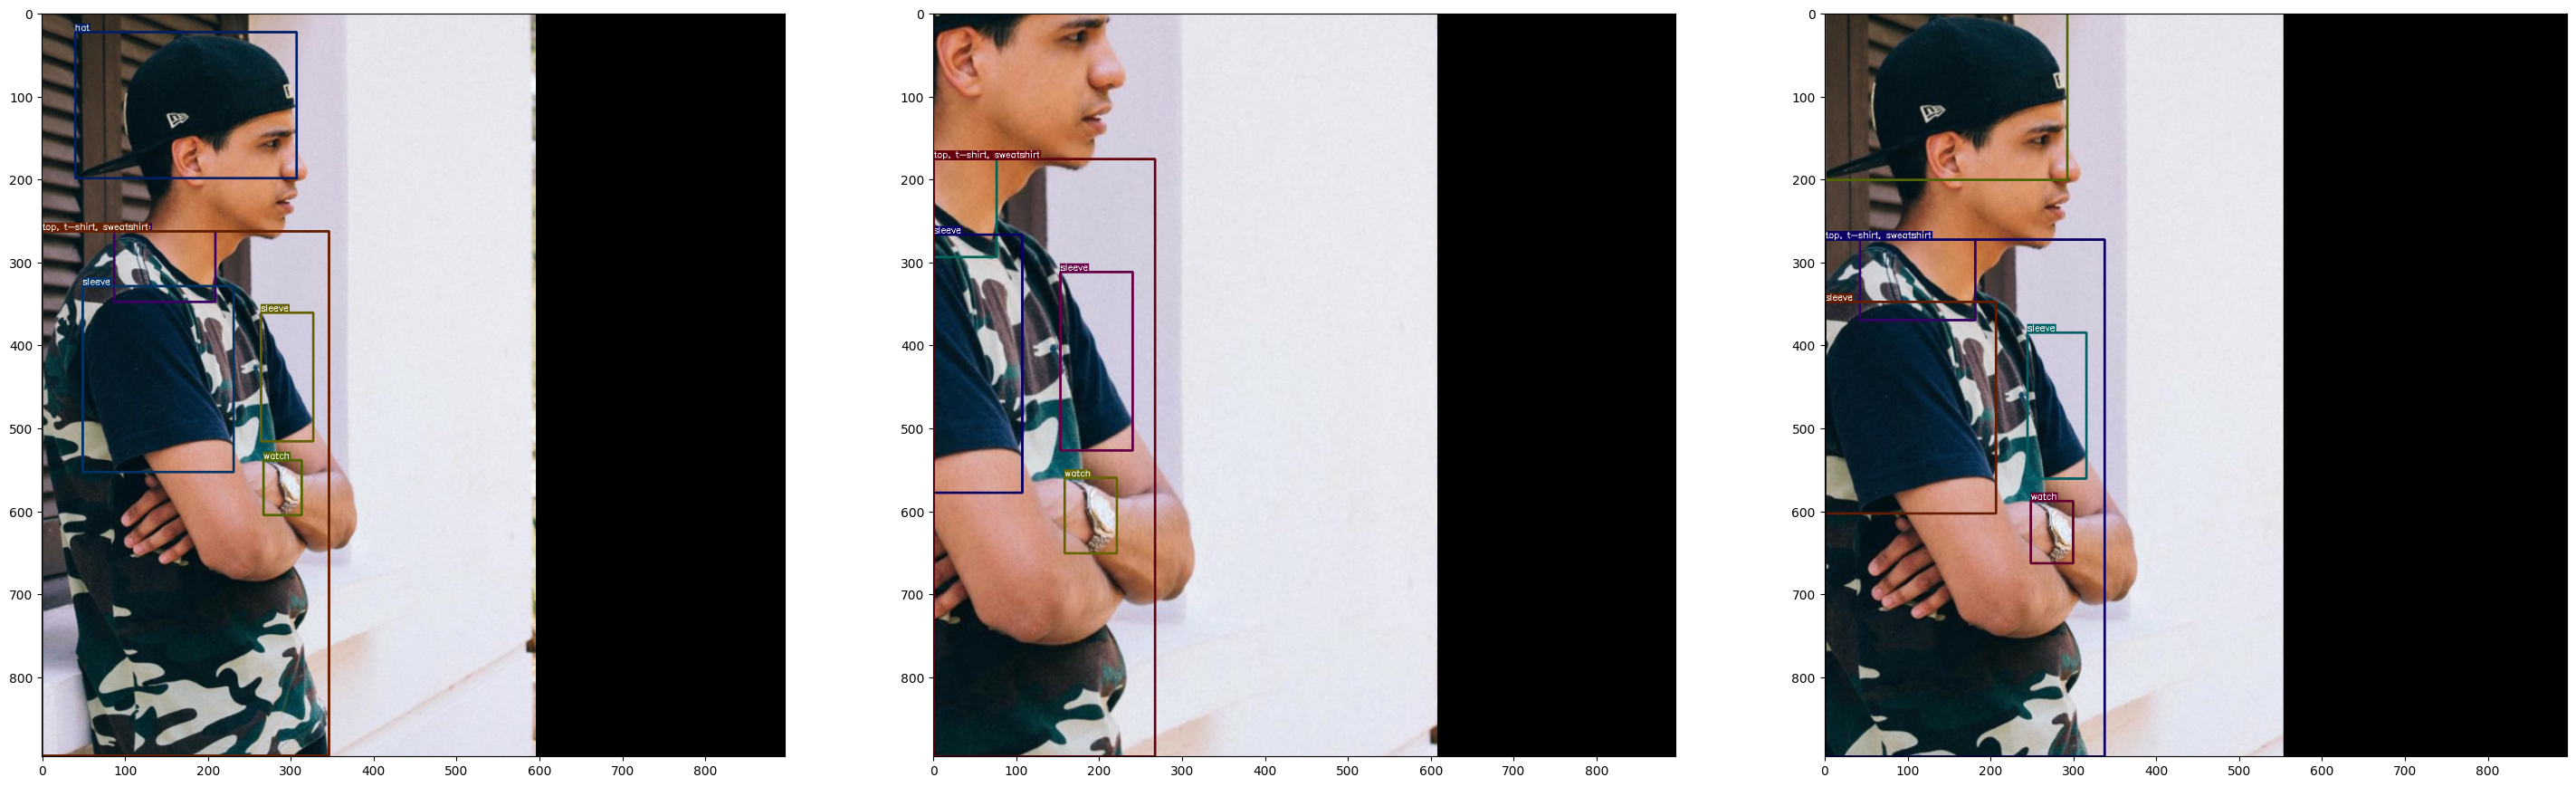

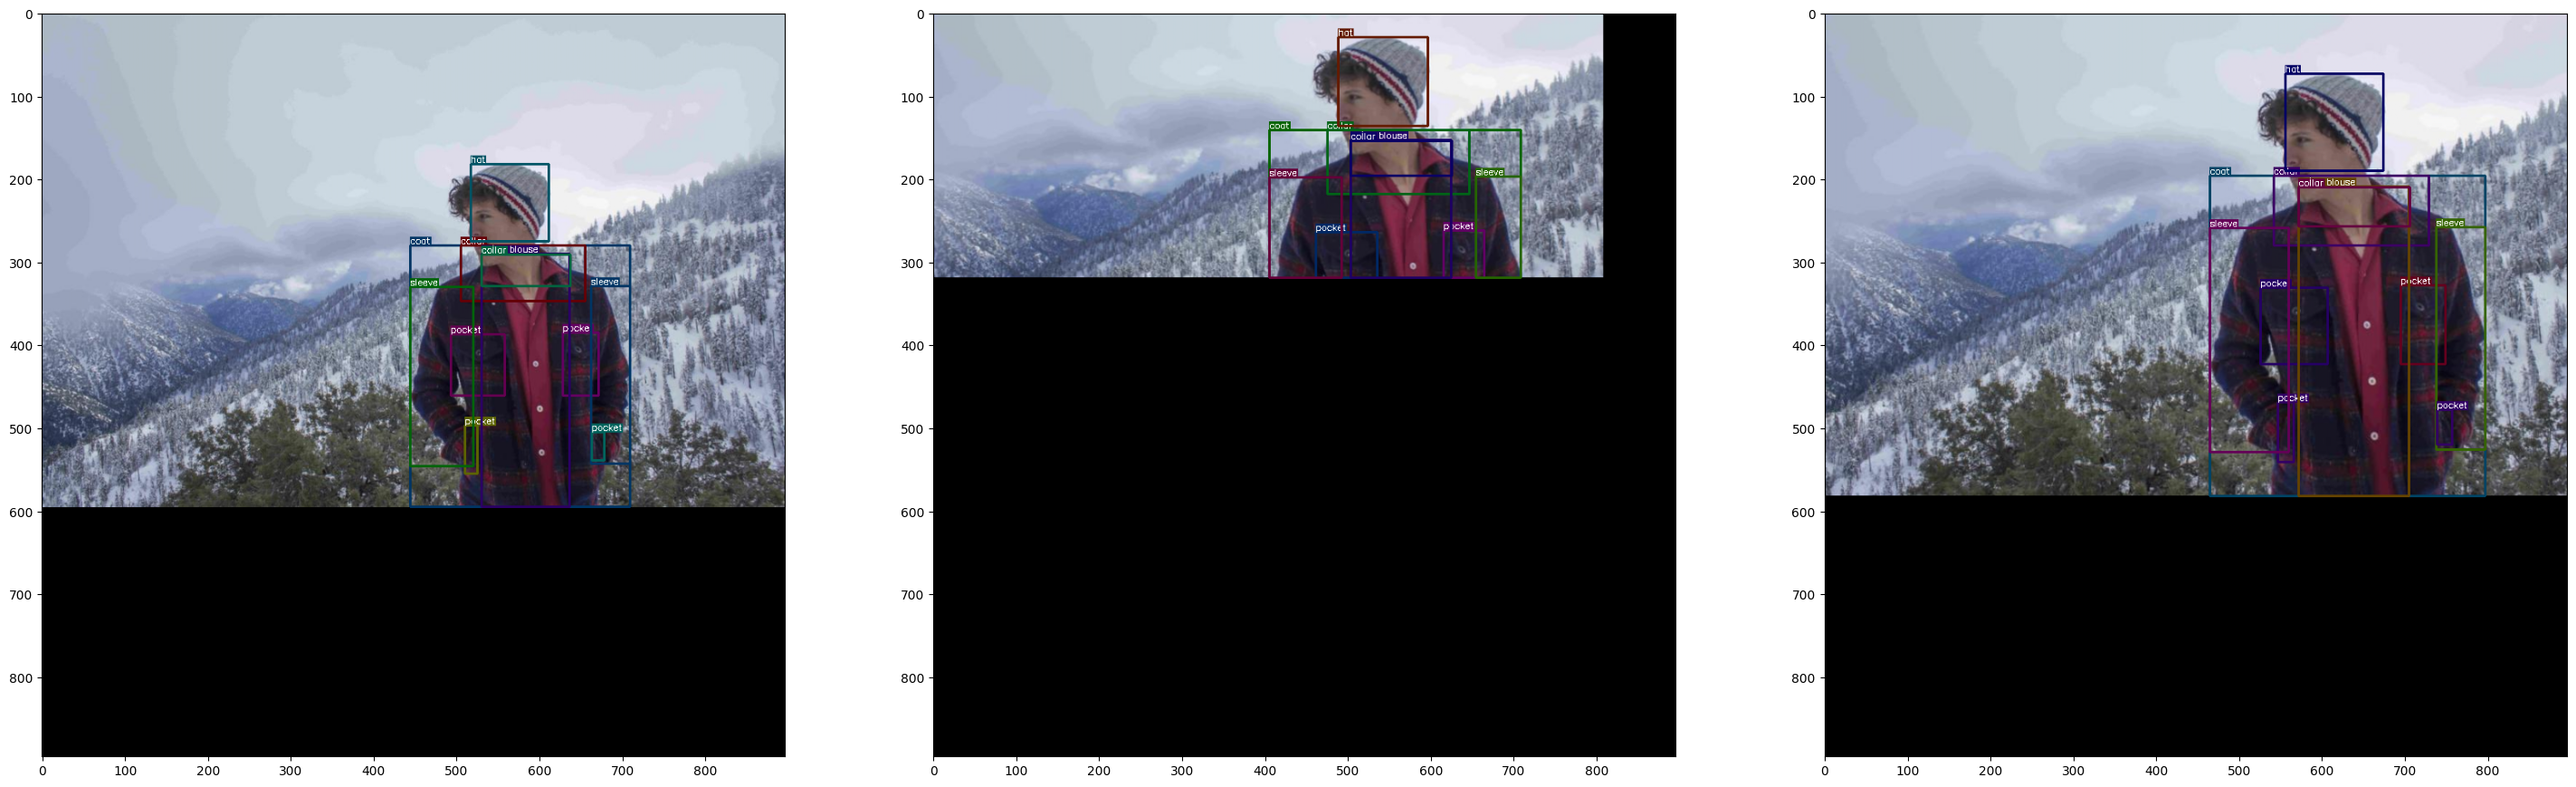

In [6]:
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]

input_size = input_sizes[opt.compound_coef]


def getLoader():
    training_transform = A.Compose([
        # A.OneOf([
        #     A.Compose([
        #         A.FromFloat(dtype='uint8'),
        #         A.FancyPCA(alpha=0.1, p=1),
        #         A.ToFloat(max_value=255.0),
        #     ]),
        #     A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=1),
        # ], p=1),
        # A.Compose([
        #     A.GaussNoise(var_limit=(0.0, 0.02), p=1),
        # ], p=1),
        A.OneOf([
            A.BBoxSafeRandomCrop(erosion_rate=0.2, p=1),
            # A.RandomCropNearBBox((0.1, 0.1))
            # A.RandomCropFromBorders(0.3, 0.3, 0.3, 0.3, p=1),
            # A.Rotate(limit=5, p=1, border_mode=cv2.BORDER_REPLICATE, value=[0, 0, 0]),
            # A.ElasticTransform(alpha=50, sigma=10, alpha_affine=0, border_mode=cv2.BORDER_REPLICATE, p=1)
        ], p=1),
        # A.Normalize(max_pixel_value=1.0, p=1.0),
        # A.HorizontalFlip(p=0.5),
        A.LongestMaxSize(max_size=input_size),
        A.RandomScale(scale_limit=(-0.25, 0), interpolation=cv2.INTER_LINEAR, p=0.5),
        A.PadIfNeeded(min_height=input_size, min_width=input_size, position=A.PadIfNeeded.PositionType.TOP_LEFT, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0], p=1.0),
    ], bbox_params=A.BboxParams(format='coco', min_visibility=0.3))
    training_set = CocoDatasetForAlbumentations(
        root_dir=os.path.join(opt.data_path, params.project_name),
        set=params.train_set,
        transform=training_transform
    )
    Subset(training_set, list(range(0, 4600)))

    return DataLoader(training_set, **training_params)

def getSomethingLoader():
    training_transform = A.Compose([
        # A.OneOf([
        #     A.Compose([
        #         A.FromFloat(dtype='uint8'),
        #         A.FancyPCA(alpha=0.1, p=1),
        #         A.ToFloat(max_value=255.0),
        #     ]),
        #     A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=1),
        # ], p=1),
        A.Compose([
            # A.GaussNoise(var_limit=(0.0, 0.02), p=1),
        ], p=1),
        A.OneOf([
            # A.BBoxSafeRandomCrop(erosion_rate=0.2, p=1),
            # A.RandomCropNearBBox((0.1, 0.1))
            A.RandomCropFromBorders(0.3, 0.3, 0.3, 0.3, p=1),
            # A.Rotate(limit=5, p=1, border_mode=cv2.BORDER_REPLICATE, value=[0, 0, 0]),
            # A.ElasticTransform(alpha=50, sigma=10, alpha_affine=0, border_mode=cv2.BORDER_REPLICATE, p=1)
        ], p=1),
        # A.Normalize(max_pixel_value=1.0, p=1.0),
        # A.HorizontalFlip(p=0.5),
        A.LongestMaxSize(max_size=input_size),
        A.RandomScale(scale_limit=(-0.25, 0), interpolation=cv2.INTER_LINEAR, p=0.5),
        A.PadIfNeeded(min_height=input_size, min_width=input_size, position=A.PadIfNeeded.PositionType.TOP_LEFT, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0], p=1.0),
    ], bbox_params=A.BboxParams(format='coco', min_visibility=0.3))
    training_set = CocoDatasetForAlbumentations(
        root_dir=os.path.join(opt.data_path, params.project_name),
        set=params.train_set,
        transform=training_transform
    )
    Subset(training_set, list(range(0, 4600)))

    return DataLoader(training_set, **training_params)


def getOriginalLoader():

    training_transform = transforms.Compose([
        # Normalizer(mean=params.mean, std=params.std),
        Resizer(input_sizes[opt.compound_coef])
    ])
    training_set = CocoDataset(
        root_dir=os.path.join(opt.data_path, params.project_name),
        set=params.train_set,
        transform=training_transform
    )

    return DataLoader(training_set, **training_params)


for iter, datas in enumerate(zip(getOriginalLoader(), getSomethingLoader(), getLoader())):
    if iter == 3:
        break

    # print(iter)
    # print(data)
    category_id_to_name = {v: k for v, k in enumerate(params.obj_list)}
    fig, axes = plt.subplots(1, 3, figsize=(36, 12))
    for ax, data in zip(axes, datas):
        img, annot = data['img'], data['annot']
        img = img
        img = img.permute(0, 2, 3, 1).numpy()
        rois = annot[:, :, :4].numpy()
        class_ids = annot[:, :, 4].numpy()
        visualize(img[0], rois[0], class_ids[0], category_id_to_name, np.ones(len(rois[0])), plot=ax)
